# Deep Learning on Ancient DNA

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
Modern contamination is a big issue in Ancient DNA research area. Up to now the most reliable way to address how ancient is an NGS sample is to use deamination pattern inference which is based on averaging thousands and millions of aligned reads. Here we present a Convolutional Neural Network (CNN) based classifier which gives a per-read prediction of how ancient a read is. We also address which exactly patterns are responsible for such classification.

### Table of Contents:
* [Deep Learning in Genomics](#Deep Learning in Genomics)
* [Extract Reads from Neanderthals](#Extract Reads from Neanderthals)
* [Extract Reads from Modern Humans](#Extract Reads from Modern Humans)
* [Prepare Data for Convolutional Neural Network](#Prepare Data for Convolutional Neural Network)
* [Run Shallow Convolutional Neural Network](#Run Shallow Convolutional Neural Network)
* [Interpret Results of Convolutional Neural Network](#Interpret Results of Convolutional Neural Network)
* [Predict Ancient Status](#Predict Ancient Status)
* [Run Deep Convolutional Neural Network](#Run Deep Convolutional Neural Network)

### Deep Learning in Genomics <a class="anchor" id="Deep Learning in Genomics"></a>

Convolutional Neural Networks (CNNs) demonstrate state-of-the-art predictions of functional motifs in genomics. CNNs are use-ful in settings in which some spatially invariant patterns in the input are expected, such as images or sequential data. The input into a CNN is typically a matrix of real values. In genomics, the input might be a DNA sequence, in which the nucleotides A, C, T and G are encoded as [1,0,0,0], [0,1,0,0], [0,0,1,0] and [0,0,0,1]. Neurons that directly read in the data input are called the first, or input, layer. Layer two consists of neurons that read in the outputs of layer one, and so on for deeper layers, which are also referred to as hidden layers. The output of the neural network is the prediction of interest, e.g., whether the input DNA is an enhancer.

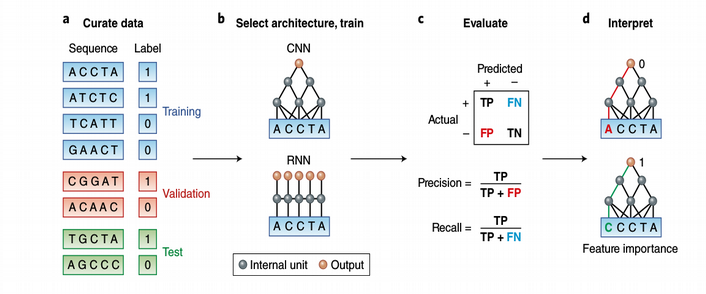

In [1]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/AncientDNA/CNN_Genomics.png')

### Extract Reads from Neanderthals <a class="anchor" id="Extract Reads from Neanderthals"></a>

We will start with extracting reads from the draft Neanderthal genome. We will use pysam Python module in order to read and parse the BAM-alignments for the draft Neanderthal genome:

In [2]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
neand = pysam.AlignmentFile("Neandertal.bam", "rb")

Let us display a few lines of the BAM-alignments for the draft Neanderthal genome:

In [3]:
iter = neand.fetch("chr1", 1, 50)
for x in iter:
    print(str(x))

M_SL-XAL_0003_30R1LAAXX:1:43:634:1649	16	0	38	84	97M	-1	-1	97	GCCCTAGCCCTAGCCTTAGCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTAACCCTAAC	array('B', [25, 27, 24, 7, 16, 11, 24, 24, 23, 24, 19, 29, 27, 10, 29, 22, 24, 30, 28, 24, 17, 12, 10, 29, 40, 40, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 38, 40, 40, 40, 40, 40, 40, 40, 36, 40, 40, 40, 40, 40, 39, 40, 40, 37, 40, 40, 40, 37, 40, 40, 23, 26, 25, 18, 21, 28, 25, 23, 19, 20, 18, 25, 28, 29, 24, 20, 18, 24, 26, 24, 23, 22, 17, 26])	[('AS', 116)]
M_SL-XAL_0003_30R1LAAXX:2:30:429:1152	16	0	43	2	65M2I26M1I41M	-1	-1	135	AACCCTAACCCTAACCCTAACACGAACCATAAACCTAACCCTAACACGAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCCTCACCCTAACCCCTAACCCTAACCCTAACCCAGAGAGA	array('B', [34, 33, 28, 9, 25, 16, 29, 32, 32, 25, 26, 28, 30, 12, 31, 30, 31, 29, 30, 35, 19, 10, 20, 25, 28, 30, 23, 25, 28, 26, 29, 30, 26, 25, 27, 24, 30, 26, 28, 22, 29, 18, 26, 29, 27, 24, 26, 26, 24, 29, 21, 24,

We can easily extract read length information and plot read length distibution:

In [4]:
iter = neand.fetch("chr1", 0, 249000000)
neand_lengths = []
for i in iter:
    neand_lengths.append(i.infer_query_length())
print(neand_lengths[0:100])

[97, 135, 65, 59, 53, 109, 65, 49, 47, 47, 57, 85, 82, 59, 64, 46, 40, 40, 37, 67, 42, 56, 63, 30, 53, 35, 44, 47, 34, 50, 43, 42, 45, 69, 62, 63, 48, 68, 62, 83, 87, 48, 41, 42, 63, 58, 33, 42, 38, 37, 37, 52, 62, 66, 61, 74, 60, 46, 71, 52, 41, 74, 74, 39, 57, 38, 113, 59, 54, 53, 62, 47, 46, 36, 73, 71, 89, 78, 44, 71, 85, 36, 48, 42, 48, 57, 49, 53, 49, 42, 40, 40, 40, 62, 48, 68, 58, 58, 83, 57]


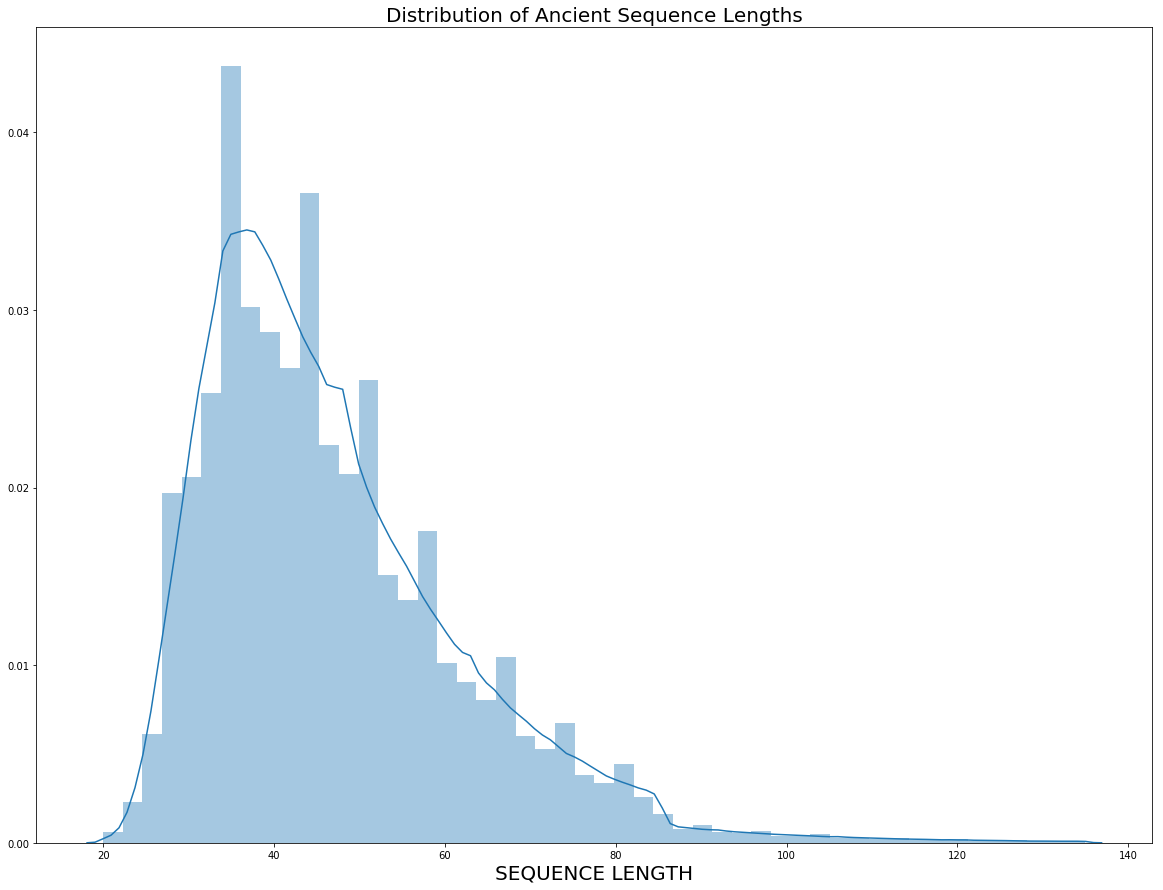

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
sns.distplot(neand_lengths)
plt.xlabel('SEQUENCE LENGTH', fontsize = 20)
plt.title('Distribution of Ancient Sequence Lengths', fontsize = 20)
plt.show()

Now we will extract read sequences with a certain read length, for example 76:

In [6]:
len(neand_lengths)

7539448

In [7]:
neand_seqs = []
for j in range(1,11):
    iter = neand.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                neand_seqs.append(i.get_forward_sequence())
len(neand_seqs)

265240

In [8]:
neand_seqs[0:10]

['AAATCATCAGTGGAAATTTAAAAAAATACACATGGCCAGGCCCCAGCCCAAATCACTAATAAGAATCTCCAAAACT',
 'ATGTGAAGCCCAACATTTAGGTTTTAAAAATCAAGCGTATAAATACAGAAGGTGGAGGGAACTTGCTTTAGACACA',
 'TCTTAAAGGGGGGTGGGAACTAAGCAGATCACAAGGGAGCTGCCCACAGAGGTCAAGACAAGGTCAGGTAGGCCGA',
 'TTTGTCTTTTAATCTGGCAACCCTAAAAGGCAAGGGCCAAAAATACCGGAGGCAAGCCAACGGATTCCAGGAGGGA',
 'ACAGATGCAGCCAGACAGAAAATAGTTTATCTTGCTGAGGTTTCTAATGTATTTGAAAGAGGCCTGGGTCTAGAAA',
 'GTCTAGAAGTCTACCCAGAGGGTTCTGTGTTGTGCACGCAAAGATAAGAACCTTCCCTGTAGGAGTTCCAGAGCCA',
 'TGGGTTGTTCTCTGAGAGGCAGGAGAGCATAGTGGTTACTAGGAAGGGAAGGACTTTGGGACTAGACTGCCTCGGC',
 'TTACTAGGAAGGGAAGGACTTTGGGACTAGACTGCCTCGGCTGAAGTCCTCTTTCTGCTTCATAGCCACGTGATCC',
 'TTCTCACCACAAAGACAGATTCAGTTATTACATATTGACAGAGTGAAAACTGAGGCACAGGTAACATGCCTAGAAT',
 'ATATGAAGCAGCAGGAGTGTTTTAATTAAAAGAAGGCAGTTGCTGTAACCAACTATAAACAAATAAAGGCTTAAAC']

We are going to implement a Convolutional Neural Network (CNN) which is typically used for image classification, in our case it will be a 1D "image". When working with images, data augmentation is known to dramatically improve performance of CNNs and make learning process more robust. For the case of genomics, data augmentation can be seen as an addition of reverse-complement sequences to the training data set. Let us use BioPython to create a reverse-complement sequence for each of the selected reads and add it to the data set.

In [9]:
from Bio.Seq import Seq
neand_reverse_complement_seqs = [str(Seq(i).reverse_complement()) for i in neand_seqs]
neand_reverse_complement_seqs[0:10]

['AGTTTTGGAGATTCTTATTAGTGATTTGGGCTGGGGCCTGGCCATGTGTATTTTTTTAAATTTCCACTGATGATTT',
 'TGTGTCTAAAGCAAGTTCCCTCCACCTTCTGTATTTATACGCTTGATTTTTAAAACCTAAATGTTGGGCTTCACAT',
 'TCGGCCTACCTGACCTTGTCTTGACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGA',
 'TCCCTCCTGGAATCCGTTGGCTTGCCTCCGGTATTTTTGGCCCTTGCCTTTTAGGGTTGCCAGATTAAAAGACAAA',
 'TTTCTAGACCCAGGCCTCTTTCAAATACATTAGAAACCTCAGCAAGATAAACTATTTTCTGTCTGGCTGCATCTGT',
 'TGGCTCTGGAACTCCTACAGGGAAGGTTCTTATCTTTGCGTGCACAACACAGAACCCTCTGGGTAGACTTCTAGAC',
 'GCCGAGGCAGTCTAGTCCCAAAGTCCTTCCCTTCCTAGTAACCACTATGCTCTCCTGCCTCTCAGAGAACAACCCA',
 'GGATCACGTGGCTATGAAGCAGAAAGAGGACTTCAGCCGAGGCAGTCTAGTCCCAAAGTCCTTCCCTTCCTAGTAA',
 'ATTCTAGGCATGTTACCTGTGCCTCAGTTTTCACTCTGTCAATATGTAATAACTGAATCTGTCTTTGTGGTGAGAA',
 'GTTTAAGCCTTTATTTGTTTATAGTTGGTTACAGCAACTGCCTTCTTTTAATTAAAACACTCCTGCTGCTTCATAT']

In [10]:
len(neand_reverse_complement_seqs)

265240

In [11]:
neand_seqs_augmented = neand_seqs + neand_reverse_complement_seqs
len(neand_seqs_augmented)

530480

In [12]:
characters = [list(i) for i in neand_seqs_augmented]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

Thus we got tens of thousands of ancient reads of certain length from just chromosome 1, later we can loop over all chromosomes and all read lengths.

### Extract Reads from Modern Humans <a class="anchor" id="Extract Reads from Modern Humans"></a>

Now we perform the same operation with the reads from Modern Humans (French). We first extract read lenth information and plot the read length distribution:

In [13]:
modern = pysam.AlignmentFile("/home/nikolay/WABI/Misc/AncientDNA/French.bam", "rb")
iter = modern.fetch("chr1", 0, 1000000)
modern_lengths = []
for i in iter:
    modern_lengths.append(i.infer_query_length())
print(modern_lengths[0:100])

[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]


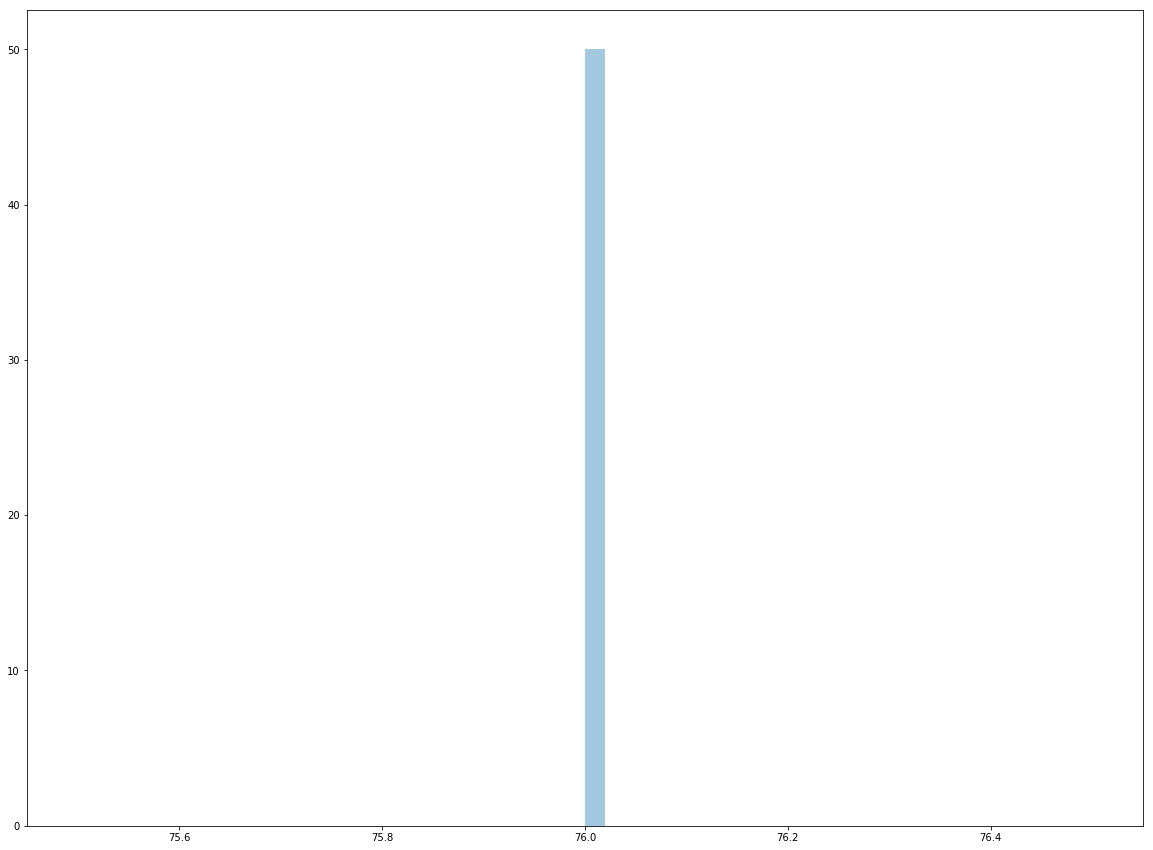

In [14]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
plt.figure(figsize=(20,15))
sns.distplot(modern_lengths)
plt.show()

Looks like we have all modern reads of the same length 76. Let us now extract as many modern reads as we had from the Neanderthal genome:

In [15]:
modern_seqs = []
for j in range(1,11):
    iter = modern.fetch("chr" + str(j))
    for i in iter:
        if len(modern_seqs) == len(neand_seqs):
            break
        else:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                modern_seqs.append(i.get_forward_sequence())
len(modern_seqs)

265240

In [16]:
modern_seqs[0:10]

['TAGCCCTAGCCCTAGCCCTAGCCCTAGCCCTAACCCTAACCCTAACCCTAGCCCTAACCCTACCCCTAACCCTAAC',
 'CCTAACCCTAACCCTAACCCTAACCCTAACCGTAACCCTAAACCCTAAACCCTAACCCTAACCCTAACCCCCCCCC',
 'TGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGCTAAGGTTAAGGGTAAGGGTTAGGGTTAGGGTTAGGGTTAGG',
 'GGTTAGGGTTAGGGTTAGGGTTAGGGTTCGGGTTAGTGTTAGTGGTTGGGTTAGGGTTAGGGTTAGGGTTAGGGAT',
 'AAGGGTTAGGGTTAGGGTTAGGGTTCGGGTTAGGGTTCGGGTTAGGGTTAGGTCTAGGGTTAGGGTTAGGGTTAGG',
 'CTCTTCCGATCTGTTAGGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTT',
 'GGGTCAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGGTAGGGGTAGGGGTAGGGGTAGGGG',
 'GGCTAGGGCTAGGGCTAGGGCTAGGGTTAGGGTTAGGGTTTAGGGTTGGGTTTAGGGTTGGGGTTGGGGTTGGGGT',
 'TAAATATAACAGGCATATTACTCATGGAGGGTTAGGGTTAGCGTTAGCGTTAGTGTTGGGGTTGGGGTTGGGGTTG',
 'GGTTAGGGTCGGGGTTAGGGTTAGGGTCAGGGGTCAGGGTCAGGGTCAGGGGTCAGGGTCGGGGTCGGGGTCAGGG']

Again as we did it for the ancient sequences, we apply data augmentation, which is the construction of reverse-complement sequences:

In [17]:
from Bio.Seq import Seq
modern_reverse_complement_seqs = [str(Seq(i).reverse_complement()) for i in modern_seqs]
modern_reverse_complement_seqs[0:10]

['GTTAGGGTTAGGGGTAGGGTTAGGGCTAGGGTTAGGGTTAGGGTTAGGGCTAGGGCTAGGGCTAGGGCTAGGGCTA',
 'GGGGGGGGGTTAGGGTTAGGGTTAGGGTTTAGGGTTTAGGGTTACGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
 'CCTAACCCTAACCCTAACCCTAACCCTTACCCTTAACCTTAGCCCTAACCCTAACCCTAACCCTAACCCTAACCCA',
 'ATCCCTAACCCTAACCCTAACCCTAACCCAACCACTAACACTAACCCGAACCCTAACCCTAACCCTAACCCTAACC',
 'CCTAACCCTAACCCTAACCCTAGACCTAACCCTAACCCGAACCCTAACCCGAACCCTAACCCTAACCCTAACCCTT',
 'AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACAGATCGGAAGAG',
 'CCCCTACCCCTACCCCTACCCCTACCCCTAGACCCTAGACCCTAGACCCTAGACCCTAGACCCTAGACCCTGACCC',
 'ACCCCAACCCCAACCCCAACCCTAAACCCAACCCTAAACCCTAACCCTAACCCTAGCCCTAGCCCTAGCCCTAGCC',
 'CAACCCCAACCCCAACCCCAACACTAACGCTAACGCTAACCCTAACCCTCCATGAGTAATATGCCTGTTATATTTA',
 'CCCTGACCCCGACCCCGACCCTGACCCCTGACCCTGACCCTGACCCCTGACCCTAACCCTAACCCCGACCCTAACC']

In [18]:
len(modern_reverse_complement_seqs)

265240

In [19]:
modern_seqs_augmented = modern_seqs + modern_reverse_complement_seqs
len(modern_seqs_augmented)

530480

In [20]:
characters = [list(i) for i in modern_seqs_augmented]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

### Prepare Data for Convolutional Neural Network <a class="anchor" id="Prepare Data for Convolutional Neural Network"></a>

Here we will prepare training and test data sets for Convolutional Neural Network (CNN). The training data set will be later split on the fly into "true training" and validation subsets when implementing cross-validation procedure for model fitting. We will start with merging Neanderthal and Modern Human sequences data sets:

In [21]:
sequences = neand_seqs_augmented + modern_seqs_augmented
len(sequences)

1060960

Now let us create a list of labels that mark Neanderthal and Modern Human sequences as 1 and 0, respectively:

In [22]:
labels = list(np.ones(len(neand_seqs_augmented))) + list(np.zeros(len(modern_seqs_augmented)))
len(labels)

1060960

The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AAATCATCAG ... CTCCAAAACT
One hot encoding of Sequence #1:
 [[ 1.  1.  1. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Now we will perform a similar operation with the sequence labels. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features.

In [24]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[ 1.  1.  1. ...,  0.  0.  0.]]
One-hot encoded labels:
 [[ 0.  0.  0. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  0.  0.  0.]]


Finally, let us split the data set into train and test sub-sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training.

In [25]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [26]:
train_features.shape

(795720, 76, 4)

In [27]:
train_labels.shape

(795720, 2)

In [28]:
test_features.shape

(265240, 76, 4)

In [29]:
test_labels.shape

(265240, 2)

Now everything is ready for the classification with Convolutional Neural Network (CNN). Here we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

### Hyperparameter Tuning <a class="anchor" id="Hyperparameter Tuning"></a>

Before starting training the CNN model, we need to figure out a few important hyperparameters such as L1 norm and Dropout regularizations as well as learning rate and batch size. Those hyperparameters will influence the performance of the model a lot, so it is better to pay attention to them. We will start with L1 norm regularization hyperparameter as it will control the overfitting in our model:

Using TensorFlow backend.


Working with L1 = 0.1
Param: 0.100000, Train: 0.500, Test: 0.500
Working with L1 = 0.01
Param: 0.010000, Train: 0.810, Test: 0.809
Working with L1 = 0.001
Param: 0.001000, Train: 0.826, Test: 0.826
Working with L1 = 0.0001
Param: 0.000100, Train: 0.835, Test: 0.834
Working with L1 = 1e-05
Param: 0.000010, Train: 0.838, Test: 0.836


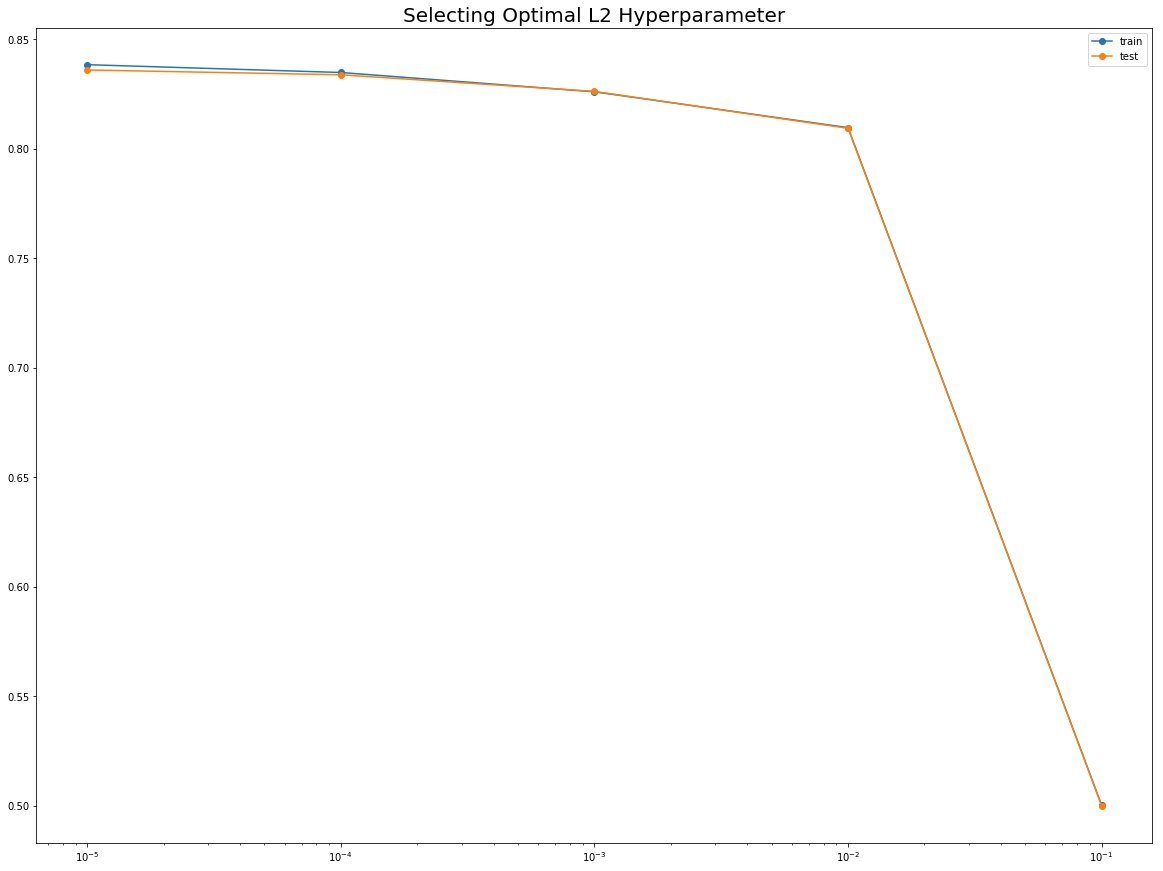

In [30]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with L1 = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu',
                     kernel_regularizer=l1(param)))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu', kernel_regularizer=l1(param)))
    model.add(MaxPooling1D(pool_size = 2))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu', 
                    kernel_regularizer=l1(param)))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = 32, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal L2 Hyperparameter', fontsize = 20)
plt.show()

Strangely enough we see that the less L1 norm regularization applied the higher is the accuracy on the test data set. However the weight regularization is known to introduce a lot of "fluctuating" behavior in the learning curves, so those accuracies might be just the results of learning curve jumping up and down. What about Dropout regularization? This is a more "stable" and more common way to regularize CNNs. Let us check it:

Working with Dropout = 0.0
Param: 0.000000, Train: 0.838, Test: 0.835
Working with Dropout = 0.2
Param: 0.200000, Train: 0.835, Test: 0.833
Working with Dropout = 0.3
Param: 0.300000, Train: 0.833, Test: 0.832
Working with Dropout = 0.4
Param: 0.400000, Train: 0.833, Test: 0.832
Working with Dropout = 0.5
Param: 0.500000, Train: 0.832, Test: 0.831
Working with Dropout = 0.6
Param: 0.600000, Train: 0.829, Test: 0.829
Working with Dropout = 0.7
Param: 0.700000, Train: 0.828, Test: 0.827


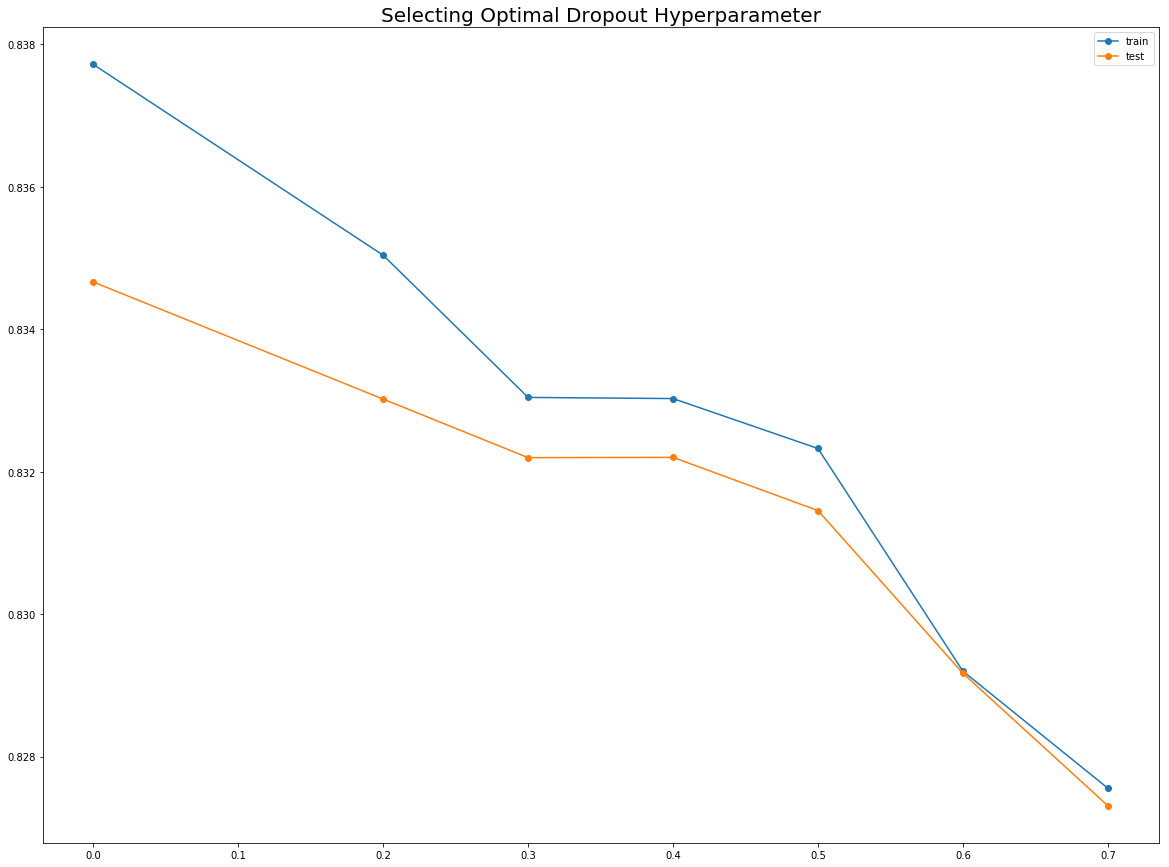

In [31]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with Dropout = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu'))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(param))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dropout(param))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = 32, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.plot(values, all_train, label='train', marker='o')
plt.plot(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal Dropout Hyperparameter', fontsize = 20)
plt.show()

Wow! Dropout does not seem to be needed either! However I suspect this is because we have performed hyperparameter testing using only 20 epochs. So when you train your CNN for a very short period of time, indeed most likely no regularization is needed, however longer training of CNN will most likely need some protection against overfitting, so we will have to use L1 / L2 norm and Dropout regularizations for later stages of training. There is another important hyperparameter which is batch size which determines how fast a CNN learns and also introduces some weak regularization function as it allows to avoid local minima. Small batch sizes are also good if you do not have lots of RAM and work with large data sets. Let us now check a few batch sizes to see which one is optimal:

Working with Batch Size = 8
Param: 8.000000, Train: 0.837, Test: 0.835
Working with Batch Size = 16
Param: 16.000000, Train: 0.836, Test: 0.833
Working with Batch Size = 32
Param: 32.000000, Train: 0.838, Test: 0.835
Working with Batch Size = 64
Param: 64.000000, Train: 0.837, Test: 0.834
Working with Batch Size = 128
Param: 128.000000, Train: 0.836, Test: 0.834
Working with Batch Size = 256
Param: 256.000000, Train: 0.835, Test: 0.833
Working with Batch Size = 512
Param: 512.000000, Train: 0.834, Test: 0.833


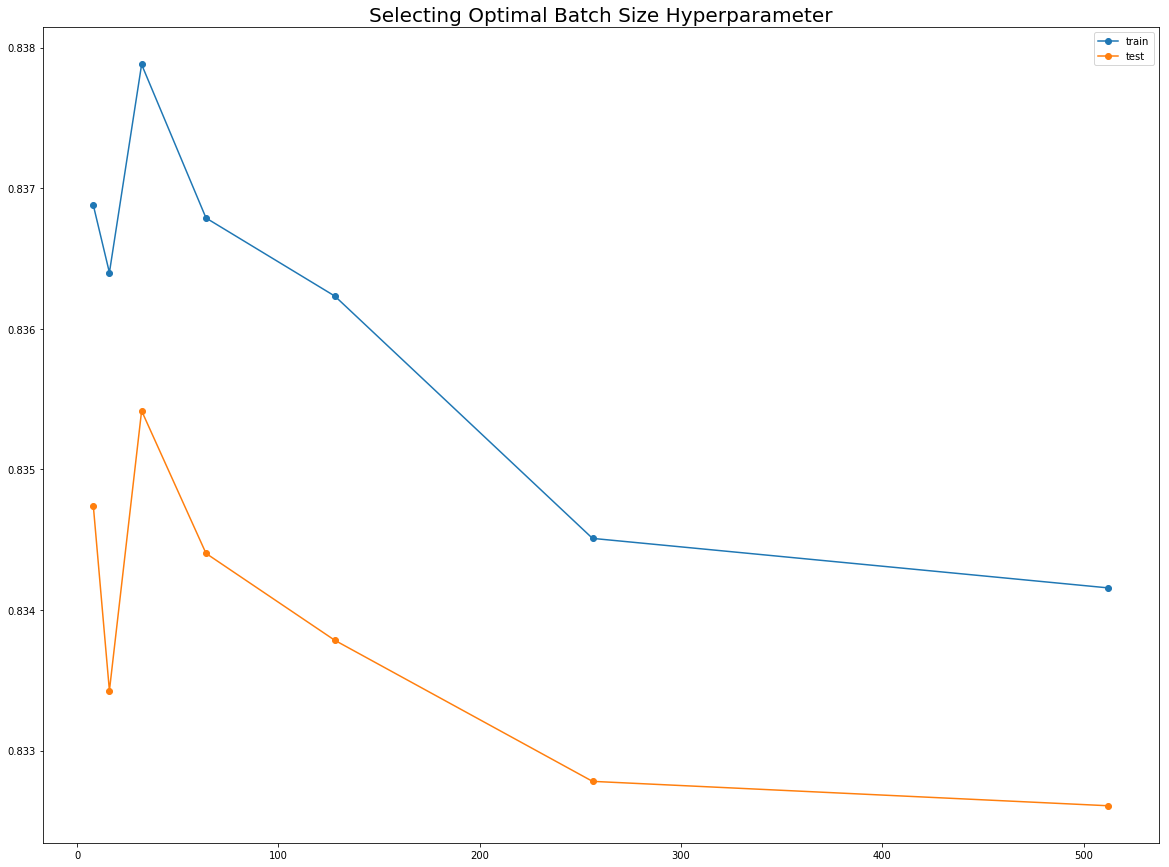

In [32]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [8, 16, 32, 64, 128, 256, 512]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with Batch Size = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu'))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 2))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = param, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.plot(values, all_train, label='train', marker='o')
plt.plot(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal Batch Size Hyperparameter', fontsize = 20)
plt.show()

### Grid Search <a class="anchor" id="Grid Search"></a>

In [33]:
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
import scipy as sp
import random as rn
import sklearn as sk
import pandas as pd

from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

import keras
from keras import metrics, regularizers, optimizers
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,15)

import warnings
warnings.filterwarnings('ignore')

print()
print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))
print("Keras Version: {}".format(keras.__version__))


Python 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas 0.23.4
Numpy 1.13.3
Scikit-Learn 0.19.0

Tensor Flow Version: 1.3.0
Keras Version: 2.0.9


In [34]:
def create_keras_model(filters = 32, neurons = 16, alpha = 0.001, kernel_size = 5, lrate = 0.01,
                       epochs = 20):
    keras_model = Sequential()
    keras_model.add(Conv1D(filters, kernel_size, padding = 'same', kernel_initializer = 'he_uniform', 
                           input_shape=(train_features.shape[1], 4), activation = 'relu',
                           kernel_regularizer=l2(alpha)))
    keras_model.add(Conv1D(filters, kernel_size, padding = 'same', kernel_initializer = 'he_uniform', 
                           activation = 'relu', kernel_regularizer=l2(alpha)))
    keras_model.add(MaxPooling1D(pool_size = 2))
    
    keras_model.add(Flatten())
    keras_model.add(Dense(neurons, kernel_initializer= 'he_uniform', activation = 'relu',
                          kernel_regularizer=l2(alpha)))
    keras_model.add(Dense(2, activation='softmax'))
    
    epochs = epochs
    lr = lrate
    decay = lr / epochs
    sgd = SGD(lr = lr, momentum = 0.9, decay = decay, nesterov = False)
    keras_model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return keras_model

#Define grid for each hyperparameter
epochs = 20
batch_size = 256
lrate = [0.001, 0.005, 0.01]
neurons = [16]
alpha = [0.001]
filters = [32]
kernel_size = [5]

#Wrap the model into KerasClassifier 
keras_model = KerasClassifier(build_fn = create_keras_model, verbose = 0, batch_size = batch_size, 
                              epochs = epochs)

#Run grid search cross-validation procedure
import time
start_time = time.time()
param_grid = dict(neurons=neurons, filters=filters, kernel_size=kernel_size, alpha=alpha, lrate=lrate)
grid = GridSearchCV(estimator = keras_model, param_grid = param_grid, n_jobs = 1, cv = 2)
grid_result = grid.fit(train_features, train_labels)

#Collect results and display best combination of hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
stop_time = time.time()
print()
print("It took {0} seconds for the program to run".format(stop_time - start_time))

Best: 0.832665 using {'alpha': 0.001, 'filters': 32, 'kernel_size': 5, 'lrate': 0.01, 'neurons': 16}

0.829926 (0.000607) with: {'alpha': 0.001, 'filters': 32, 'kernel_size': 5, 'lrate': 0.001, 'neurons': 16}
0.831475 (0.000220) with: {'alpha': 0.001, 'filters': 32, 'kernel_size': 5, 'lrate': 0.005, 'neurons': 16}
0.832665 (0.000327) with: {'alpha': 0.001, 'filters': 32, 'kernel_size': 5, 'lrate': 0.01, 'neurons': 16}

It took 14920.069274187088 seconds for the program to run


### Run Shallow Convolutional Neural Network <a class="anchor" id="Run Shallow Convolutional Neural Network"></a>

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of an ancient site on a sequence). We will start with defining Convolutional Neural Network (CNN) model and summarize the fitting parameters of the model. 

In [73]:
import math
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.constraints import maxnorm

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

model = Sequential()

model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape=(train_features.shape[1], 4), activation = 'relu',
                 kernel_regularizer=l1(0.00001), kernel_constraint=maxnorm(3)))
model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 activation = 'relu',
                 kernel_regularizer=l1(0.00001), kernel_constraint=maxnorm(3)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu', 
                kernel_regularizer=l1(0.00001), kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

epochs = 200
lrate = 0.001
decay = lrate / epochs
#sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
# learning schedule callback
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 76, 32)            672       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 76, 32)            5152      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 32)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1216)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                19472     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
__________

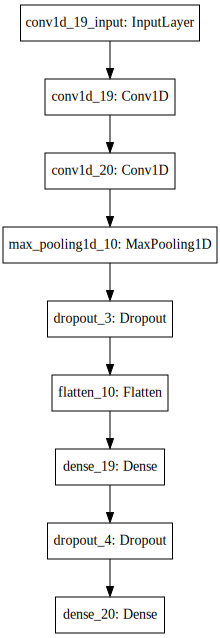

In [74]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

In [75]:
#history = model.fit(train_features, train_labels, epochs = epochs, verbose = 1, validation_split = 0.25,
#                   batch_size = 256, shuffle = True, callbacks = callbacks_list)
history = model.fit(train_features, train_labels, epochs = epochs, verbose = 1, validation_split = 0.25,
                   batch_size = 128, shuffle = True)

Train on 596790 samples, validate on 198930 samples
Epoch 1/200
596790/596790 [==============================] - 128s 215us/step - loss: 0.4851 - binary_accuracy: 0.7812 - val_loss: 0.4542 - val_binary_accuracy: 0.8029
Epoch 2/200
596790/596790 [==============================] - 127s 213us/step - loss: 0.4429 - binary_accuracy: 0.8106 - val_loss: 0.4363 - val_binary_accuracy: 0.8143
Epoch 3/200
596790/596790 [==============================] - 138s 231us/step - loss: 0.4312 - binary_accuracy: 0.8162 - val_loss: 0.4294 - val_binary_accuracy: 0.8165
Epoch 4/200
596790/596790 [==============================] - 142s 238us/step - loss: 0.4263 - binary_accuracy: 0.8188 - val_loss: 0.4240 - val_binary_accuracy: 0.8202
Epoch 5/200
596790/596790 [==============================] - 149s 250us/step - loss: 0.4233 - binary_accuracy: 0.8204 - val_loss: 0.4220 - val_binary_accuracy: 0.8210
Epoch 6/200
596790/596790 [==============================] - 148s 247us/step - loss: 0.4213 - binary_accuracy: 0.

596790/596790 [==============================] - 147s 247us/step - loss: 0.3882 - binary_accuracy: 0.8363 - val_loss: 0.3930 - val_binary_accuracy: 0.8327
Epoch 97/200
596790/596790 [==============================] - 147s 246us/step - loss: 0.3884 - binary_accuracy: 0.8362 - val_loss: 0.3944 - val_binary_accuracy: 0.8322
Epoch 98/200
596790/596790 [==============================] - 147s 246us/step - loss: 0.3883 - binary_accuracy: 0.8363 - val_loss: 0.3936 - val_binary_accuracy: 0.8334
Epoch 99/200
596790/596790 [==============================] - 150s 251us/step - loss: 0.3880 - binary_accuracy: 0.8363 - val_loss: 0.3933 - val_binary_accuracy: 0.8334
Epoch 100/200
596790/596790 [==============================] - 146s 244us/step - loss: 0.3883 - binary_accuracy: 0.8360 - val_loss: 0.3935 - val_binary_accuracy: 0.8332
Epoch 101/200
596790/596790 [==============================] - 145s 244us/step - loss: 0.3877 - binary_accuracy: 0.8363 - val_loss: 0.3932 - val_binary_accuracy: 0.8325
Epo

596790/596790 [==============================] - 149s 249us/step - loss: 0.3835 - binary_accuracy: 0.8383 - val_loss: 0.3902 - val_binary_accuracy: 0.8348
Epoch 193/200
596790/596790 [==============================] - 146s 244us/step - loss: 0.3837 - binary_accuracy: 0.8381 - val_loss: 0.3896 - val_binary_accuracy: 0.8347
Epoch 194/200
596790/596790 [==============================] - 150s 252us/step - loss: 0.3831 - binary_accuracy: 0.8385 - val_loss: 0.3901 - val_binary_accuracy: 0.8345
Epoch 195/200
596790/596790 [==============================] - 149s 250us/step - loss: 0.3835 - binary_accuracy: 0.8383 - val_loss: 0.3907 - val_binary_accuracy: 0.8347
Epoch 196/200
596790/596790 [==============================] - 152s 255us/step - loss: 0.3833 - binary_accuracy: 0.8382 - val_loss: 0.3906 - val_binary_accuracy: 0.8348
Epoch 197/200
596790/596790 [==============================] - 147s 246us/step - loss: 0.3830 - binary_accuracy: 0.8383 - val_loss: 0.3891 - val_binary_accuracy: 0.8348


Let us visualize the training and cross-validated model loss and accuracy:

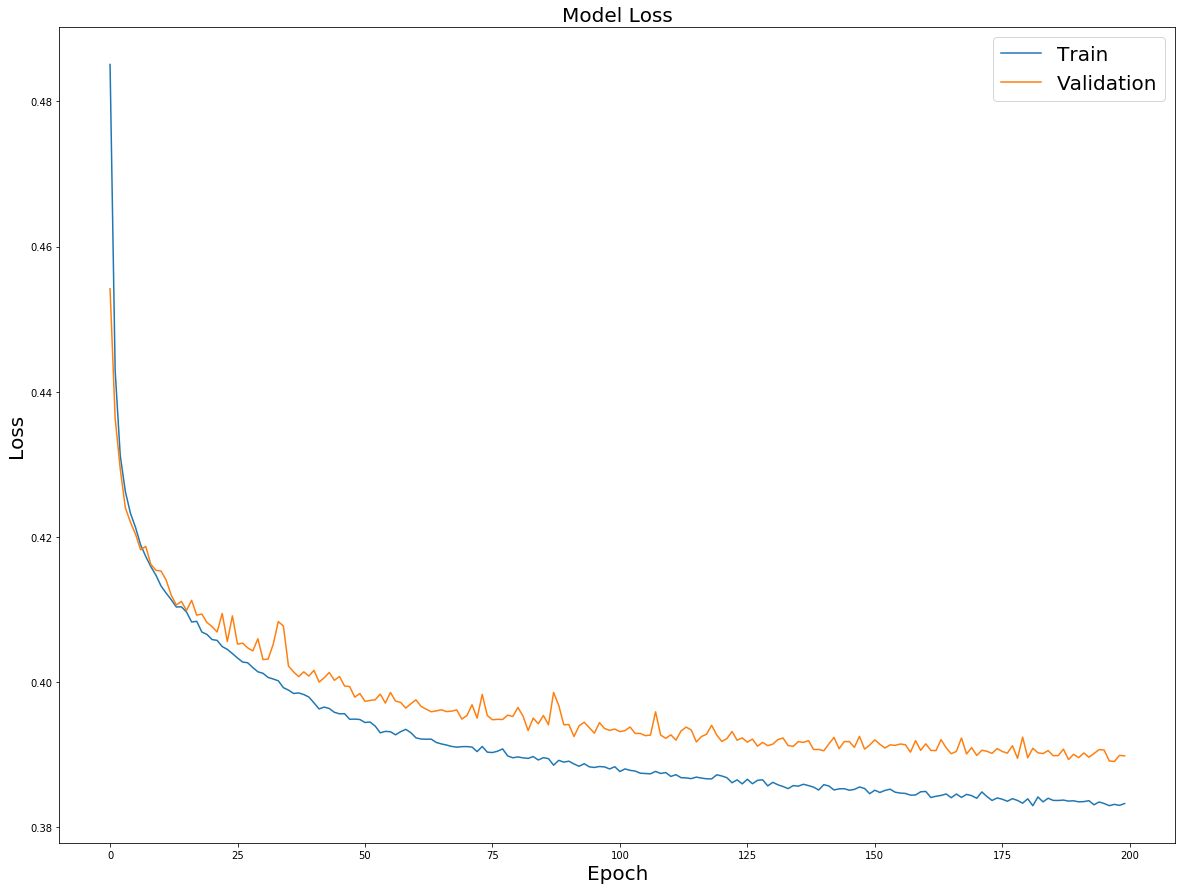

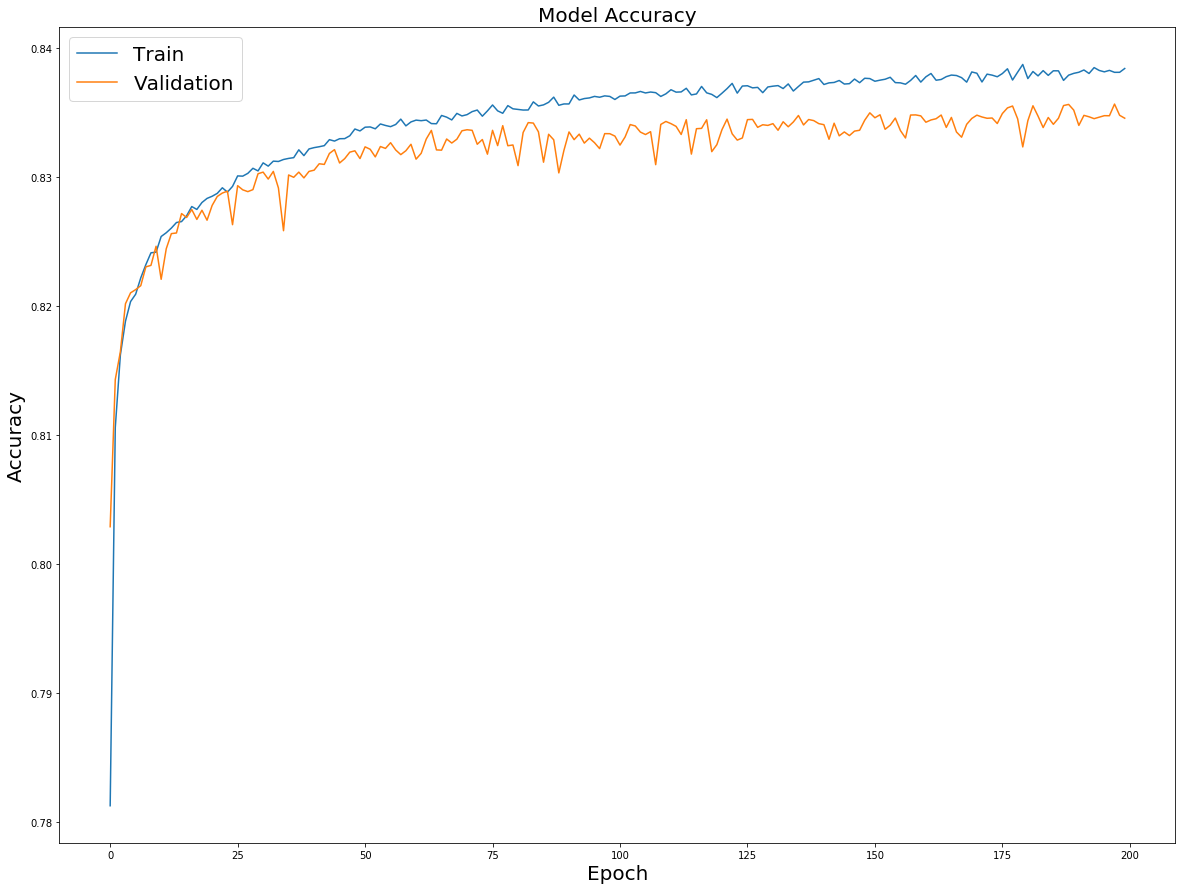

In [76]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Now we are going to save the trained model and use it later for making predictions on independent samples like the ones from Mezmayskaya Neanderthals which are known to have a very low level of modern human contamination:

In [53]:
model.save('DeepLearningAncientDNA_ShallowModel.h5')

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix.

Confusion matrix:
 [[106670  25991]
 [ 16766 115813]]


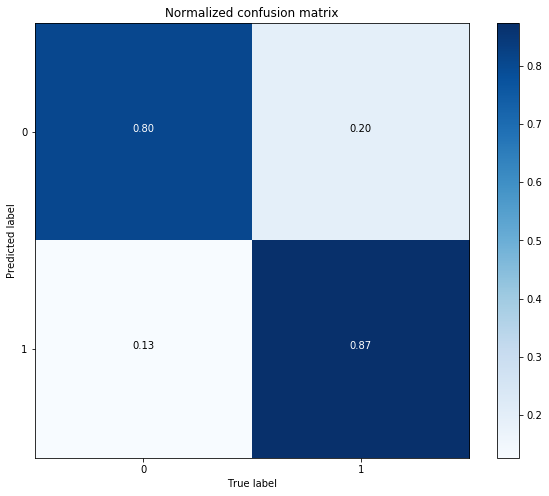

In [54]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [55]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.88%


Therefore the final accuracy of classification is around 84%, it is not fantastic but we can do it much better later. The results so far should allow you to conclude that the neural network is quite effective in learning to distinguish ancient and non-ancient sequences. But can we understand why the neural network classifies a training point in the way that it does? Now it is time for model interpretation.

### Interpret Results of Convolutional Neural Network <a class="anchor" id="Interpret Results of Convolutional Neural Network"></a>

To interpret the results of the CNN, we can compute a simple **saliency map**, which is the gradient of the model's prediction with respect to each individual nucleotide. In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides are most informative for descrimination between ancient and modern sequences.

In [56]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

Here we will take a random ancient read and show that the ends of the read are responsible for read classification as the bases at the ends of the read demonstrate the highst importartance for the prediction:

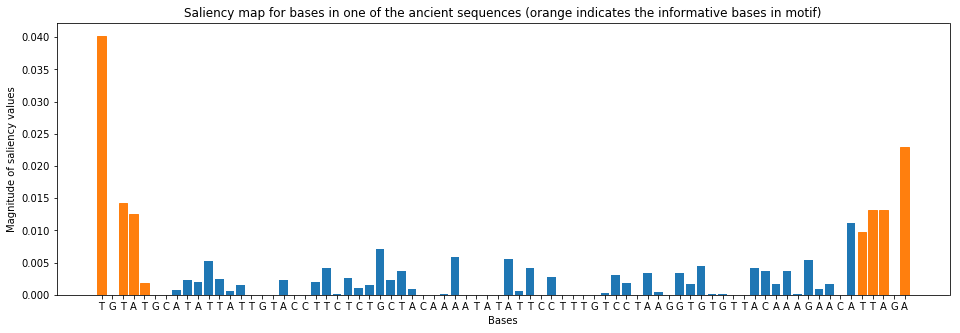

In [57]:
sequence_index = 12
K.set_learning_phase(1) #set learning phase
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(0,6)]
[barlist[j].set_color('C1') for j in range(71,76)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the ancient sequences'
          ' (orange indicates the informative bases in motif)');
plt.show()

We can see that the nucleotides at the ends of the reads tend to be more important for the prediction, which agrees with the common knowledge that the ends of ancient reads tend to be deaminated.

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different hyper-parameters, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the ancient motifs.

### Predict Ancient Status <a class="anchor" id="Predict Ancient Status"></a>

Now we can use the trained CNN for generating predictions of ancient status for each read in a given sample. Let us use Mezmayskaya 1 Neanderthal sample which is known to have a very low modern DNA comtamination and check what would the percentage of contaminant reads. For this purpose, we again need to select reads of leangth 76 since our CNN was trained only on those reads:

In [44]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
mez = pysam.AlignmentFile("Mez1.bam", "rb")

In [45]:
mez_seqs = []
for j in range(1,23):
    iter = mez.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                mez_seqs.append(i.get_forward_sequence())
len(mez_seqs)

3451

In [46]:
mez_seqs[0:10]

['CGAACAGCATACCCCCGATTCCGCTACGACCAACTCATACACCTCCTATGAAAAAACTTCCTACCACTCACCCTAA',
 'ACCAACTCATACACCTCCTATGAAAAAACTTCCTACCACTGACCCTAGCACTACTTGTATGATATGTCTCCATACC',
 'GCCCCCATCTCAATCATATACCAAATTTCTCCCTCACTAAACGTAAGCCTTCTCCTCACTCTTTCAATCTTATCCA',
 'TATTCTGATTTTTCGGCCACCCTGAAGTTTATATTCTCATCCTACCAGGCTTCGGAATAATCTCCCATATTGTAAC',
 'GTAGCGGAGGTGAAATATGCTCGTGTGTCTACGTCTATTCCTACCGTAAATATATGGTGTGCTCACACGATAAACC',
 'TCTAAAAATCTTTGAAATAGGGCCCGTATTTACTCTATAGCACCCCCTCTACCCCCTCTAGAGCCCACTGTAAAGC',
 'CACCAACCACCCAACTATCTATAAACCTAGCCATGGCCATCCCCTTATGAGCGGGCGCAGTGATTATAGGCTTTCG',
 'CACCAACCACCCAACTATCTATAAACCTAGCCATGGCCATCCCCTTATGAGCGGGCGCAGTGATTATAGGCTTTCG',
 'TCAGCCTACTCATTCAACCAGTAGCCCTGGCCGTACGCCTAACCGCTAACATTACTGCAGGTCACCTACTCATGCA',
 'CTTAACCGACCTCTTCTTATTCCTTTTTTTCTATTCTGGCTCACGCAGTAAATGGAAGATGGCATTGAAGGAGCTC']

Again we need to one-hot encode the Mezmayskaya 1 Neanderthal sequences:

In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
mez_input_features = []

for sequence in mez_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  mez_input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
mez_input_features = np.stack(mez_input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',mez_seqs[0][:10],'...',mez_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',mez_input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CGAACAGCAT ... CTCACCCTAA
One hot encoding of Sequence #1:
 [[ 0.  0.  1. ...,  0.  1.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


Now it is time to predict class, i.e. "ancient" ot "modern contaminant" for each read:

In [48]:
from keras.models import load_model
mez_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = mez_model.predict_classes(mez_input_features)

3451/3451 [==============================] - 1s 242us/step


In [49]:
sum(class_pred == 1)/len(mez_seqs)

0.70298464213271517

Thus we conclude that the majority of the reads, approximately **70%**, are indeed ancient since most of the time we predict status 1 (ancient) for the reads, we predict that Mezmayskaya 1 Neanderthal sample contains approximately 30% of modern DNA contamination. Let us compare this percentage of ancient reads with the corresponding number from modern human sample: 

In [50]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
han = pysam.AlignmentFile("Han.bam", "rb")

In [51]:
han_seqs = []
for j in range(1,2):
    iter = han.fetch('chr' + str(j), 1, 1000000)
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                han_seqs.append(i.get_forward_sequence())
len(han_seqs)

15018

In [52]:
han_seqs[0:10]

['CCCTACCCCTACCCCTACCCCTACCCCTACCCCTACCCCTAACCCTAACCCGAACCCGAACCCGAACCCTAACCCG',
 'GGTTGGGGTTAGGGTTAGGATTAGGGTTAGGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGCGTTAGGGTTGGGG',
 'ACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCGTAACCC',
 'GGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTAAGGGGTAGGGTTAGGGTTAGGTGTAGGTCT',
 'TTAGGGTTAAGGGTTAAGGGTTAGGGTTCGGGTTAGGGTTAGGGTTAGGGTTAGGGGTTCGGGTTAGGGTGCGGGG',
 'CGAACCCGAACCCGAACCCTAAACCCTAAACCCTAAACCCTAAACCCTAAACCCTAACCCTAACCCTAACCCTAAC',
 'GGGTTCGGGTTAGGGTTCGGGTTCGGGTTCGGGTTCGGGGTTAGGGGTTAGGGGTTAGGGGTCAGGGTAAAGGTCA',
 'GTCAGGGGTCAGGGGTCAAGGGTCGGGGTCGGGGGCCAAGGGCCGGGGTCGGGGGCGGGGTAAGGGTGAGGGGGAG',
 'AGCCCTGCGCTGGGGAGGCCGGACCTTTGGAGACTGTGTGTGGGTGCCTGGGCACTGACTTCTGCAACCACCTGAG',
 'AGGCCGGACCTTTGGAGACTGTGTGTGGGGGCCTGGGCACTGACTTCTGCAACCACCTGAGCGCGGGCATCCTGTG']

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 0 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
han_input_features = []

for sequence in han_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  han_input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
han_input_features = np.stack(han_input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',han_seqs[0][:10],'...',han_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',han_input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCCTACCCCT ... CCCTAACCCG
One hot encoding of Sequence #1:
 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  1.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [54]:
from keras.models import load_model
han_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = han_model.predict_classes(han_input_features)

15018/15018 [==============================] - 3s 172us/step


In [55]:
sum(class_pred == 1)/len(han_seqs)

0.21540817685444133

Thus, the modern human sample has approximately **22% of ancient reads**, or more correctly "ancient looking" reads. Ideally, if our shallow CNN was perfect, we should obtain close to 100% of reads in the Mezmayskaya 1 Neanderthal sample to be ancient and close to 0% of reads in the modern Han human sample to be ancient. However, our shallow CNN still does a pretty good job since it is a simple "ancient / non-ancient" decision maker, which in principle can be an alternative to **mapDamage** deamination pattern analysis.

Since our CNN provides a per-read ancient status assignment, let us now separate the 70% of "ancient" reads (or what was predicted by CNN to be "ancient") in the Mezmayskaya 1 Neanderthal sample from the 30% of "modern contaminant" reads and run mapDamage on those two bam-files. The hypothesis is that we should see a much stronger deamination pattern in the 70% "ancient reads" and a much weaker signal in the 30% "modern contaminant reads".

In [56]:
from keras.models import load_model
mez_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = mez_model.predict_classes(mez_input_features)

3451/3451 [==============================] - 1s 231us/step


In [57]:
mez = pysam.AlignmentFile("Mez1.bam", "rb")
mez_76 = pysam.AlignmentFile("Mez1_76.bam", "wb", template=mez)

for j in range(1,23):
    iter = mez.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                mez_76.write(i)
mez.close()
mez_76.close()

In [58]:
import pysam
mez = pysam.AlignmentFile("Mez1_76.bam", "rb")
ancient_mez = pysam.AlignmentFile("Mez1_Ancient.bam", "wb", template=mez)
modern_mez = pysam.AlignmentFile("Mez1_Modern.bam", "wb", template=mez)

for read, k in zip(mez.fetch(), range(class_pred.shape[0])):
    if class_pred[k]==1:
        ancient_mez.write(read)
    else:
        modern_mez.write(read)
mez.close()
ancient_mez.close()
modern_mez.close()

In [59]:
#mapDamage -i Mez1_Ancient.bam -r hg18.fa
#mapDamage -i Mez1_Modern.bam -r hg18.fa

The deamination profiles for "ancient" and "modern" reads look very similar meaning that the 30% of reads predicted to be modern contaminants by the CNN model are most likely ancient and we need to improve oi CNN model in order to get close to 100% of reads to be predicted to be ancient in the Mezmayskaya 1 Neanderthal sample.

### Run Deep Convolutional Neural Network <a class="anchor" id="Run Deep Convolutional Neural Network"></a>

Here we will configure a 3-block VGG-like Deep Convolutional Neural Network. We will use Batch Normalization and Dropour regularization in order to improve performance of the model:

In [60]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l1

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform', 
                 input_shape=(train_features.shape[1], 4)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

epochs = 50
#lrate = 0.01
#decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9)
#model.load_weights("weights.best.hdf5")
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 76, 32)            672       
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 32)            128       
_________________________________________________________________
activation_1 (Activation)    (None, 76, 32)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 76, 32)            5152      
_________________________________________________________________
batch_normalization_2 (Batch (None, 76, 32)            128       
_________________________________________________________________
activation_2 (Activation)    (None, 76, 32)            0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 38, 32)            0         
__________

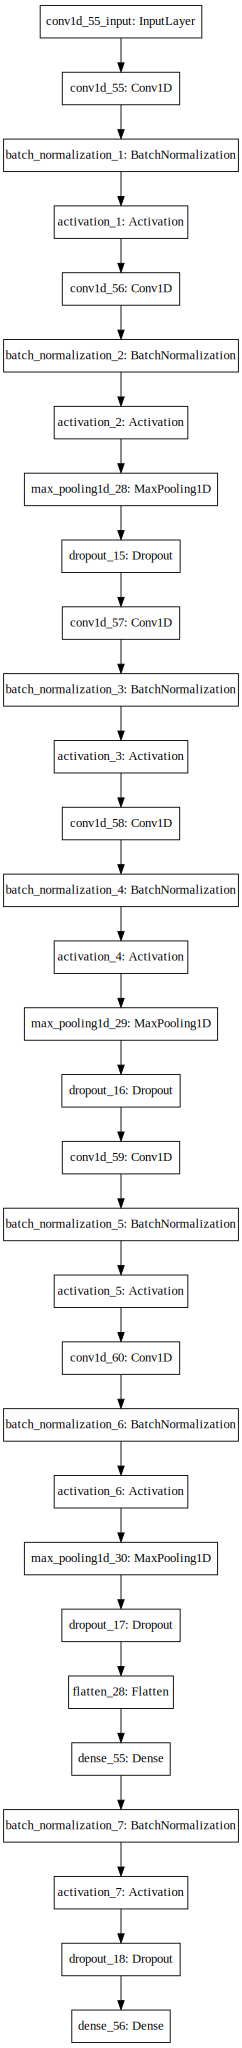

In [61]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [62]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
rlrp = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.0001)

history = model.fit(train_features, train_labels, callbacks=[rlrp, checkpoint], 
                    epochs=epochs, verbose=1, validation_split=0.25, batch_size=256, shuffle=True)

Train on 596790 samples, validate on 198930 samples
Epoch 1/50
596790/596790 [==============================] - 1469s 2ms/step - loss: 0.4121 - binary_accuracy: 0.8158 - val_loss: 0.3891 - val_binary_accuracy: 0.8276
Epoch 2/50
596790/596790 [==============================] - 1450s 2ms/step - loss: 0.3838 - binary_accuracy: 0.8299 - val_loss: 0.3808 - val_binary_accuracy: 0.8325
Epoch 3/50
596790/596790 [==============================] - 1445s 2ms/step - loss: 0.3748 - binary_accuracy: 0.8344 - val_loss: 0.3734 - val_binary_accuracy: 0.8351
Epoch 4/50
596790/596790 [==============================] - 1449s 2ms/step - loss: 0.3701 - binary_accuracy: 0.8367 - val_loss: 0.3715 - val_binary_accuracy: 0.8361
Epoch 5/50
596790/596790 [==============================] - 1445s 2ms/step - loss: 0.3667 - binary_accuracy: 0.8383 - val_loss: 0.3690 - val_binary_accuracy: 0.8372
Epoch 6/50
596790/596790 [==============================] - 1449s 2ms/step - loss: 0.3638 - binary_accuracy: 0.8393 - val_l

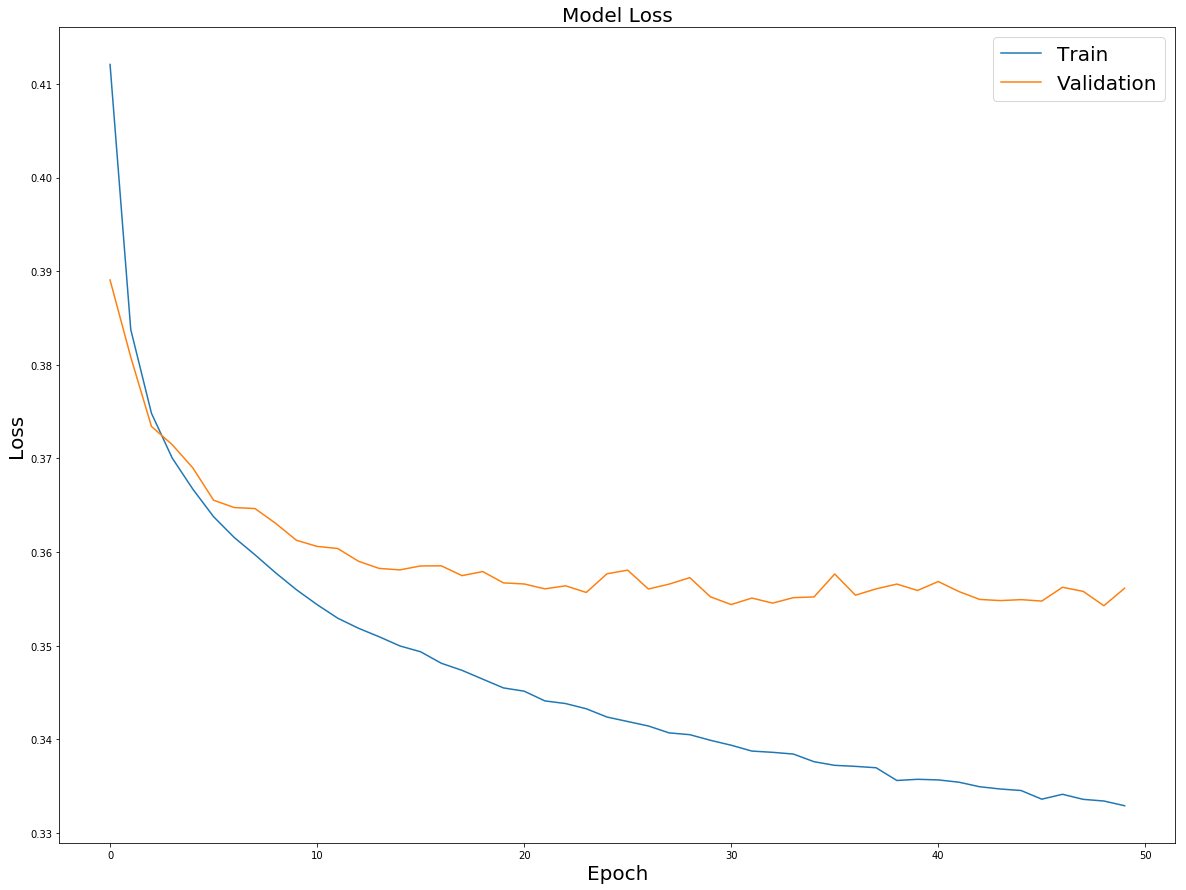

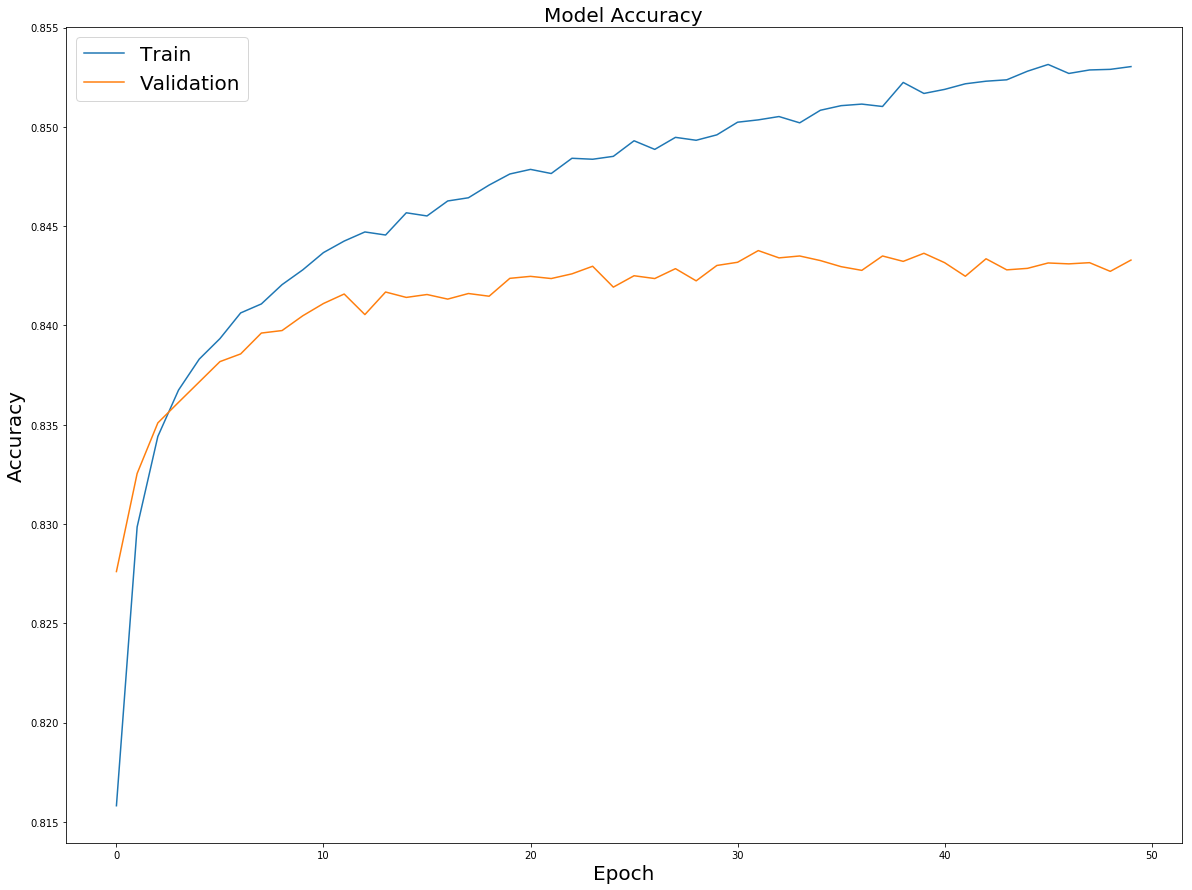

In [63]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

It looks like we do not have major problems with overfitting thanks to Dropout and Batch Normalization, i.e.  training and validation loss and accuracy curves follow each other very well. However, bad news is that 50 epochs (which took approximately 10 hours on my laptop) was not enough to achieve high enough accuracy and we probably have to train for much longer in order to see a considerable progress. Nevertheless the slopes of the curves look promising meaning that the problem is learnable and we might get better results in the future. Let us now save the Deep Model and continue with evaluation of the model:

In [64]:
model.save('DeepLearningAncientDNA_DeepModel.h5')

Confusion matrix:
 [[108445  24216]
 [ 19671 112908]]


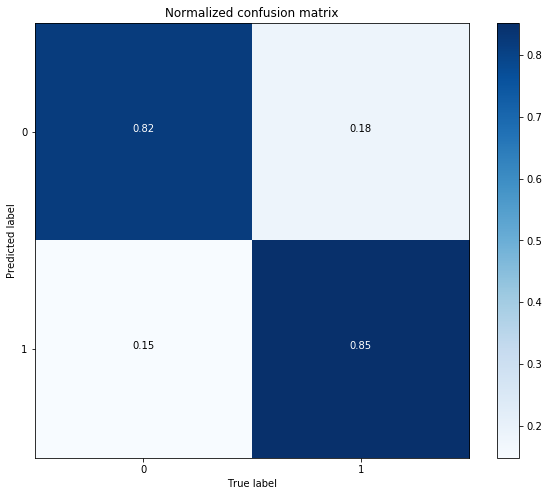

In [65]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [66]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.46%


So the accuracy is around 84% meaning that the Deep Model did not outperform substantially the Shallow Model. However, while the Shallow MOdel was clearly overfitting and was unlikely to achieve higher accuracies with more training, the Deep Model trend looks more promising and we should train for longer time.

### Implementing VGG Architecture

In [97]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import plot_model

def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = Conv1D(filters=n_filters, kernel_size=3, padding='same', activation='relu')(layer_in)
    layer_in = MaxPooling1D(pool_size=2, strides=2)(layer_in)
    #layer_in = Dropout(0.3)(layer_in)
    return layer_in

visible = Input(shape=(76, 4))
layer = vgg_block(visible, 32, 2)
layer = vgg_block(layer, 64, 2)
layer = vgg_block(layer, 128, 4)
flatten_layer = Flatten()(layer)
dense_layer = Dense(128, kernel_initializer= 'he_uniform', activation = 'relu')(flatten_layer)
#dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(2, activation='softmax')(dense_layer)

model = Model(inputs=visible, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 76, 4)             0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 76, 32)            416       
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 76, 32)            3104      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 38, 64)            6208      
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 38, 64)            12352     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 19, 64)            0         
__________

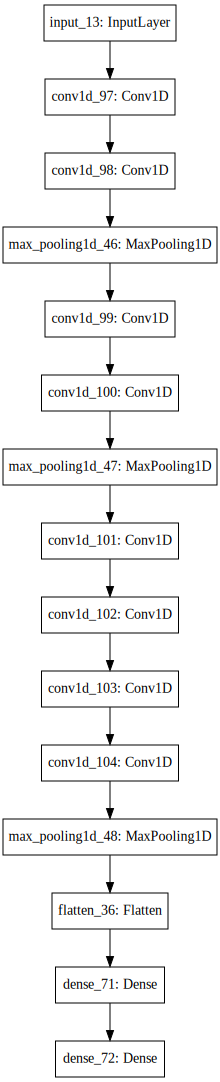

In [98]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [99]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
rlrp = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.0001)

history = model.fit(train_features, train_labels, callbacks=[rlrp, checkpoint], 
                    epochs=20, verbose=1, validation_split=0.25, batch_size=32, shuffle=True)

Train on 596790 samples, validate on 198930 samples
Epoch 1/20
596790/596790 [==============================] - 877s 1ms/step - loss: 0.3861 - binary_accuracy: 0.8275 - val_loss: 0.3798 - val_binary_accuracy: 0.8302
Epoch 2/20
596790/596790 [==============================] - 928s 2ms/step - loss: 0.3685 - binary_accuracy: 0.8362 - val_loss: 0.3673 - val_binary_accuracy: 0.8361
Epoch 3/20
596790/596790 [==============================] - 940s 2ms/step - loss: 0.3627 - binary_accuracy: 0.8391 - val_loss: 0.3601 - val_binary_accuracy: 0.8402
Epoch 4/20
596790/596790 [==============================] - 953s 2ms/step - loss: 0.3583 - binary_accuracy: 0.8410 - val_loss: 0.3580 - val_binary_accuracy: 0.8409
Epoch 5/20
596790/596790 [==============================] - 964s 2ms/step - loss: 0.3555 - binary_accuracy: 0.8426 - val_loss: 0.3596 - val_binary_accuracy: 0.8418
Epoch 6/20
596790/596790 [==============================] - 963s 2ms/step - loss: 0.3524 - binary_accuracy: 0.8440 - val_loss: 0

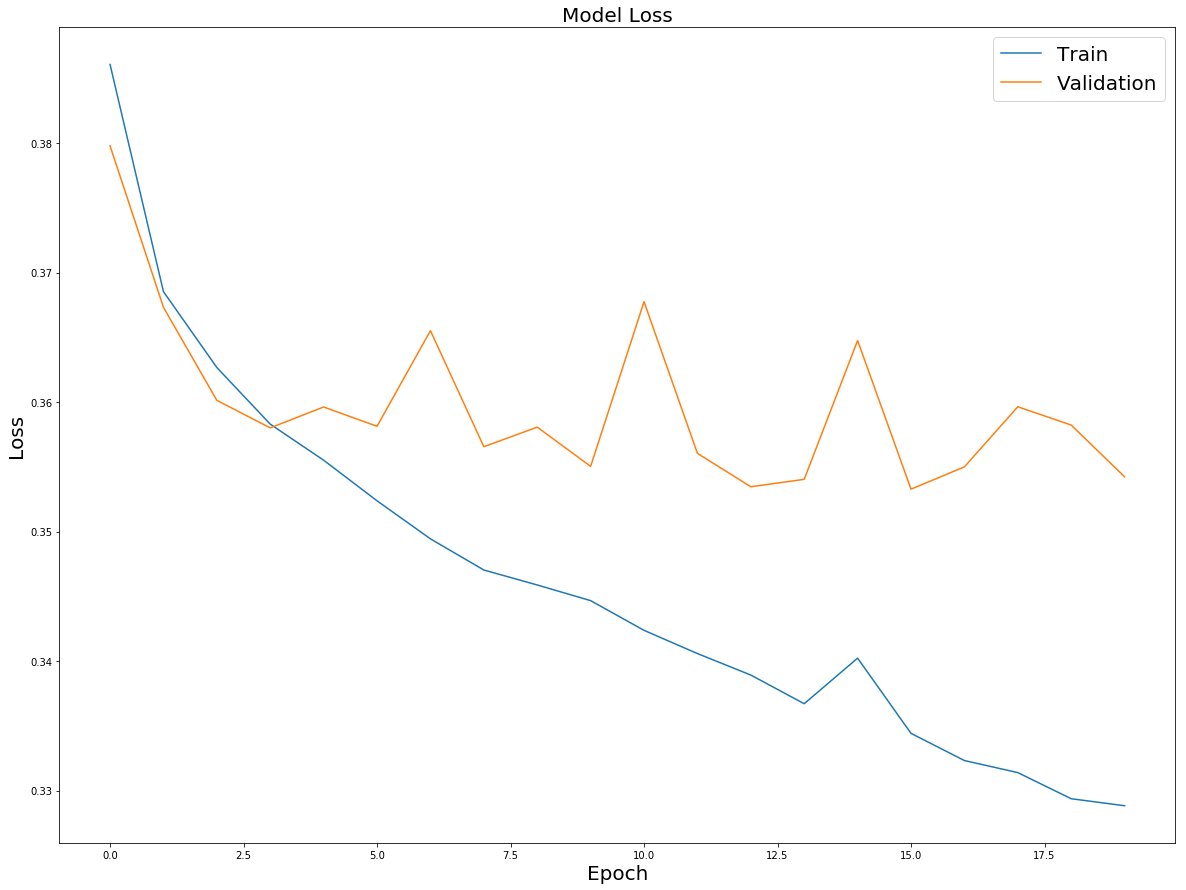

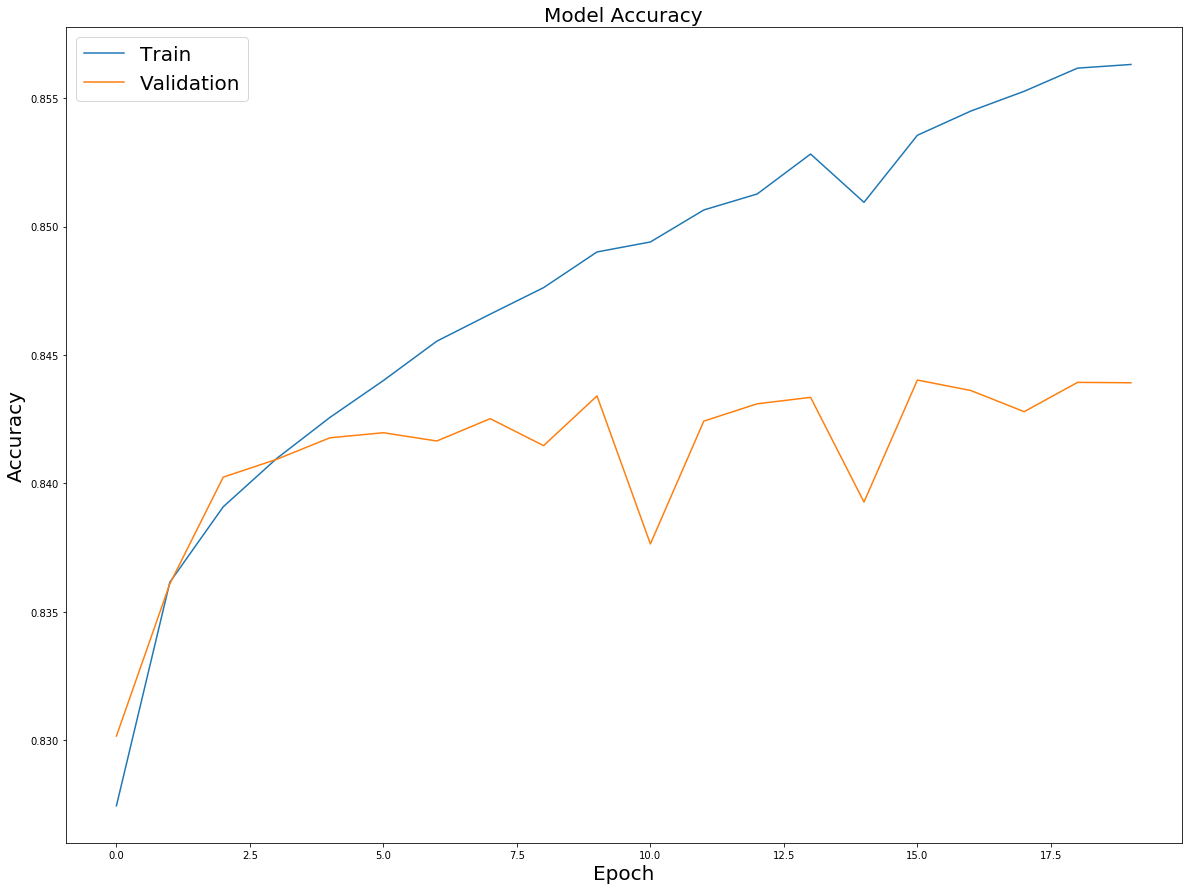

In [100]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[109561  23100]
 [ 18427 114152]]


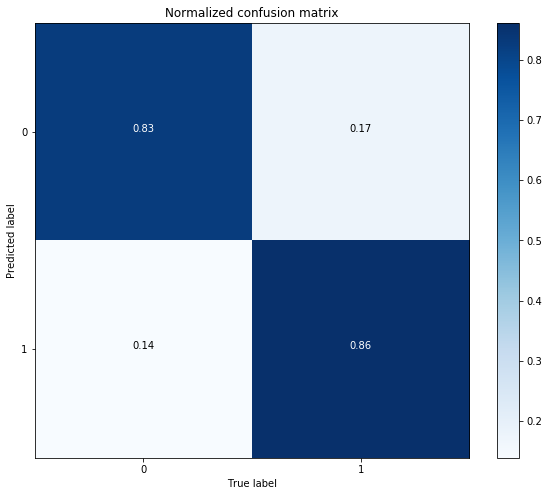

In [101]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [102]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.34%


### Implementing ResNet Architecture

In [112]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import add
from keras.utils import plot_model

def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv1D(n_filters, 1, padding = 'same', activation = 'relu',
                             kernel_initializer = 'he_normal')(layer_in)

    conv1 = Conv1D(n_filters, 3, padding= 'same', activation= 'relu', 
                   kernel_initializer = 'he_normal')(layer_in)
    conv1 = Dropout(0.3)(conv1)

    conv2 = Conv1D(n_filters, 3, padding = 'same', activation = 'linear',
                   kernel_initializer = 'he_normal')(conv1)
    conv2 = Dropout(0.3)(conv2)
    layer_out = add([conv2, merge_input])
    layer_out = Activation('relu')(layer_out)
    return layer_out

visible = Input(shape=(76, 4))
layer = residual_module(visible, 32)
flatten_layer = Flatten()(layer)
dense_layer = Dense(16, kernel_initializer= 'he_uniform', activation = 'relu')(flatten_layer)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(2, activation='softmax')(dense_layer)

# create model
model = Model(inputs=visible, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# summarize model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 76, 4)        0                                            
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 76, 32)       416         input_17[0][0]                   
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 76, 32)       0           conv1d_109[0][0]                 
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 76, 32)       3104        dropout_31[0][0]                 
__________________________________________________________________________________________________
dropout_32

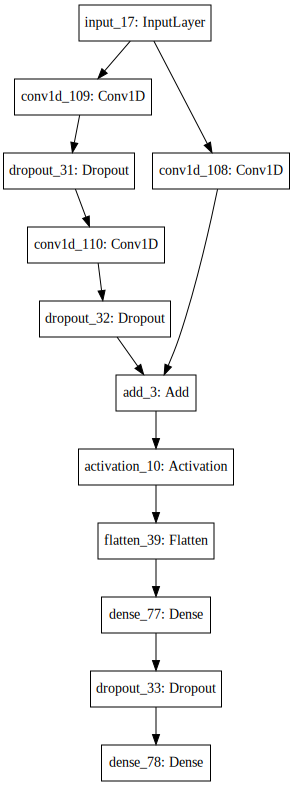

In [113]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [114]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
rlrp = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.0001)

history = model.fit(train_features, train_labels, callbacks=[rlrp, checkpoint], 
                    epochs=20, verbose=1, validation_split=0.25, batch_size=32, shuffle=True)

Train on 596790 samples, validate on 198930 samples
Epoch 1/20
596790/596790 [==============================] - 210s 351us/step - loss: 0.4594 - binary_accuracy: 0.7852 - val_loss: 0.4341 - val_binary_accuracy: 0.8017
Epoch 2/20
596790/596790 [==============================] - 212s 355us/step - loss: 0.4331 - binary_accuracy: 0.8008 - val_loss: 0.4334 - val_binary_accuracy: 0.8038
Epoch 3/20
596790/596790 [==============================] - 212s 356us/step - loss: 0.4276 - binary_accuracy: 0.8057 - val_loss: 0.4220 - val_binary_accuracy: 0.8135
Epoch 4/20
596790/596790 [==============================] - 215s 360us/step - loss: 0.4180 - binary_accuracy: 0.8137 - val_loss: 0.4162 - val_binary_accuracy: 0.8166
Epoch 5/20
596790/596790 [==============================] - 214s 359us/step - loss: 0.4120 - binary_accuracy: 0.8185 - val_loss: 0.4102 - val_binary_accuracy: 0.8193
Epoch 6/20
596790/596790 [==============================] - 213s 357us/step - loss: 0.4102 - binary_accuracy: 0.8203 -

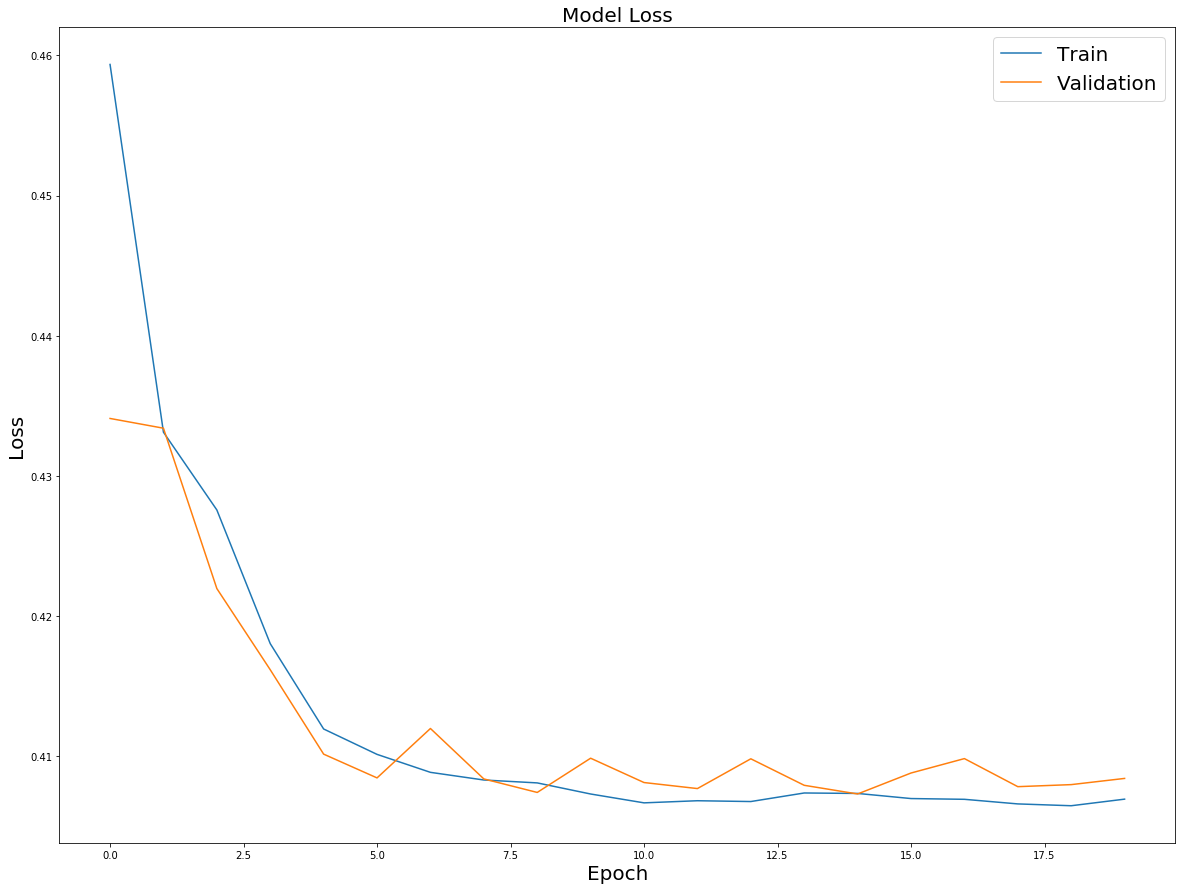

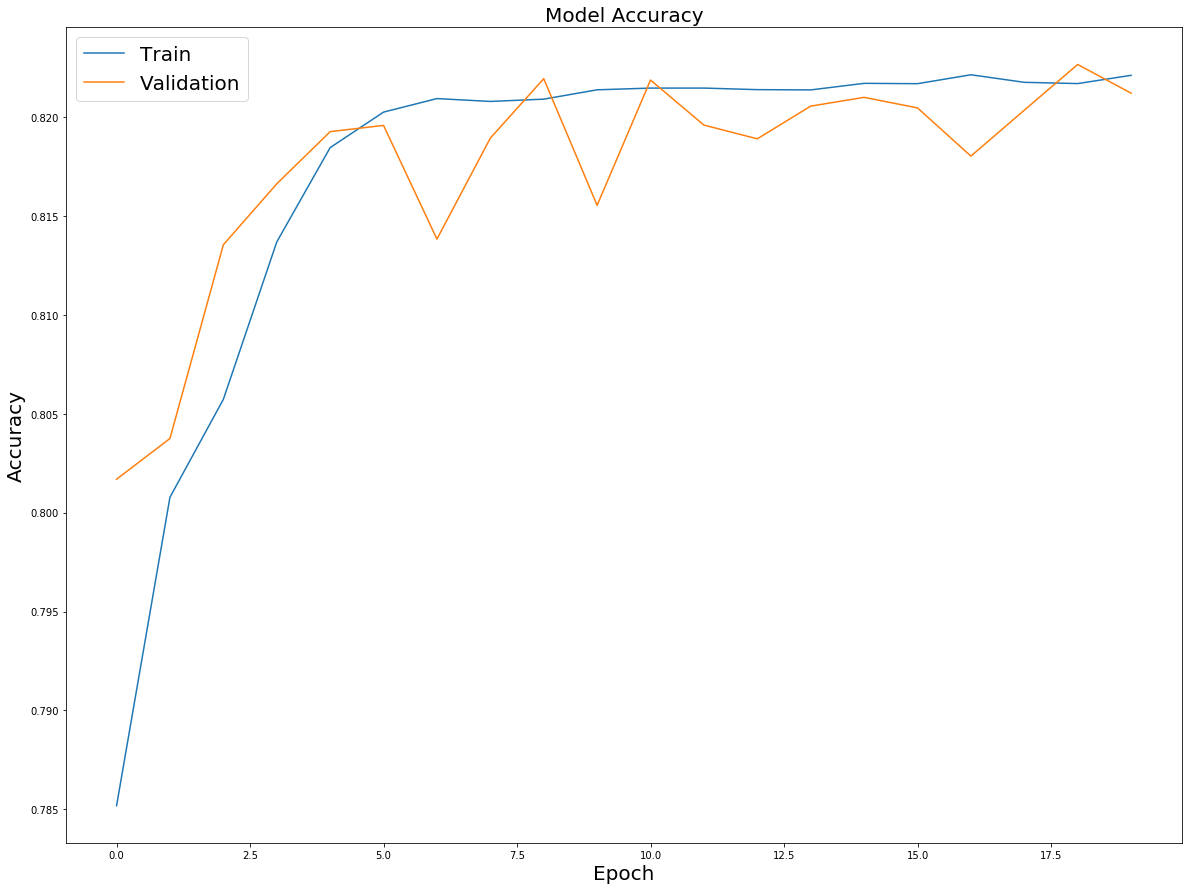

In [115]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()